<img src="./assets/img/teclab_logo.png" alt="Teclab logo" width="170">

**Author**: Hector Vergara ([LinkedIn](https://www.linkedin.com/in/hector-vergara/))

**Repository**: [ml_clasificacion_regresion](https://github.com/hhvergara/ml_clasificacion_regresion/)

**Python Notebook**: [API4.ipynb](https://github.com/hhvergara/ml_clasificacion_regresion/blob/main/API4.ipynb)

----

# API 4:

### Situación

La propuesta Ames Housing ha permitido contar con una interesante mirada sobre las potencialidades de un modelo según lo requerido por la empresa.
Para cerrar esta fase de exploración, la empresa ha solicitado realizar un análisis PCA.

No olvidar que PCA es una técnica de reducción de la dimensionalidad que se utiliza para extraer características importantes de un conjunto de datos y representarlas en un espacio de menor dimensión.

Al reducir el número de dimensiones, PCA puede ayudar a mejorar la eficiencia computacional, reducir el ruido y aumentar la interpretación de los datos.

### Consignas
Realizar un análisis PCA. Seleccionar columnas específicas del conjunto de datos original para su análisis y se reemplazan los valores faltantes con la media.

Luego, los datos se normalizan mediante la estandarización (con la clase StandardScaler), para que las diferentes características tengan la misma importancia en el análisis.

El modelo PCA se ajusta con __n_components=16__, lo que significa que el análisis resultará en 16 componentes principales.


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

__version__ = '0.0.1'
__email__ = 'hhvservice@gmail.com'
__author__ = 'Hector Vergara'
__annotations__ = 'https://www.linkedin.com/in/hector-vergara/'
__base_dir__ = Path().absolute()
__data_dir__ = os.path.join(__base_dir__, 'data')
filename_data = os.path.join(__data_dir__, 'AmesHousing.csv')
printing = lambda text: print("\033[92m" + text + "\033[0m")

In [2]:
# 📘 Libraries
def print_error_metrics(y_test, y_pred, model_name):
    """Print the error metrics of the model."""
    error_dict = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }
    printing(f"Error metrics for {model_name}:")
    [
        print(f"📏 {metric} (SVR {model_name}): {value:,.2f}")
        for metric, value in error_dict.items()
    ]
    return error_dict


def clean_dataframe(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    '''
        clean dataframe: delete columns with more than _threshold_ of missing values

        :param df: dataframe to clean

        :param threshold: threshold for the percentage of missing values (more than 50% by default)
    '''
    # 1. Calculate the percentage of null values in each column
    null_percent = df.isnull().mean()

    # 2. Filtering columns with more than threshold null values
    cols_to_drop = null_percent[null_percent > threshold]

    # 3. Show the columns to be dropped
    print(f"Columns affected with more than {threshold * 100}% of missing values:")
    print(cols_to_drop.sort_values(ascending=False))
    clean_df = df.drop(cols_to_drop.index, axis=1)
    return clean_df

def remove_outliers_zscore(df: pd.DataFrame, column: str, threshold: int = 3) -> pd.DataFrame:
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    return df[abs_z_scores < threshold]




## ✅ Exploring and cleaning the data

In [3]:
# Load data from kaggle dataset
# Dataset Source: https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset
df = pd.read_csv(filename_data)
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [5]:
# Show the number of missing values of the columns:
pd.set_option('display.max_rows', None)
printing("Dataframe shape: " + str(df.shape))
df.isnull().sum().sort_values(ascending=False)

Dataframe shape: (2930, 82)


Pool QC            2917
Misc Feature       2824
Alley              2732
Fence              2358
Mas Vnr Type       1775
Fireplace Qu       1422
Lot Frontage        490
Garage Cond         159
Garage Finish       159
Garage Yr Blt       159
Garage Qual         159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
Bsmt Qual            80
Bsmt Cond            80
BsmtFin Type 1       80
Mas Vnr Area         23
Bsmt Full Bath        2
Bsmt Half Bath        2
BsmtFin SF 1          1
Garage Cars           1
Electrical            1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
Garage Area           1
Paved Drive           0
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
TotRms AbvGrd         0
Sale Condition        0
Sale Type             0
Yr Sold               0
Mo Sold               0
Misc Val              0
Functional            0
Fireplaces            0
Pool Area       

In [6]:
# Now we will check the percentage of NaN values in each column:

# 1. Counting NAN values from dataset:
nan_count = df.apply(lambda col: col.isin([np.nan]).sum())

# 2. Calculate the percentage of NaN values in each column:
nan_percent = nan_count / len(df)

# 3. creating a summary of columns with NaN values:
nan_summary = nan_percent[nan_percent > 0.5].sort_values(ascending=False)

printing("Summary of columns with more than 50% of NAN values:")
print(nan_summary)


Summary of columns with more than 50% of NAN values:
Pool QC         0.995563
Misc Feature    0.963823
Alley           0.932423
Fence           0.804778
Mas Vnr Type    0.605802
dtype: float64


In [31]:
clean_df = clean_dataframe(df, threshold=0.5)
clean_df.head(10)

Columns affected with more than 50.0% of missing values:
Pool QC         0.995563
Misc Feature    0.963823
Alley           0.932423
Fence           0.804778
Mas Vnr Type    0.605802
dtype: float64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,Reg,Lvl,AllPub,...,170,0,0,0,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,...,0,0,144,0,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,189000


In [8]:
count = clean_df.nunique().sort_values(ascending=False)
printing(f""" % Number of unique values in each column:
{(count*100)/clean_df.shape[0]}
""")

 % Number of unique values in each column:
Order              100.000000
PID                100.000000
Lot Area            66.894198
Gr Liv Area         44.095563
Bsmt Unf SF         38.805461
1st Flr SF          36.962457
Total Bsmt SF       36.109215
SalePrice           35.221843
BsmtFin SF 1        33.959044
2nd Flr SF          21.672355
Garage Area         20.580205
Mas Vnr Area        15.187713
Wood Deck SF        12.969283
BsmtFin SF 2         9.351536
Open Porch SF        8.600683
Enclosed Porch       6.245734
Lot Frontage         4.368601
Screen Porch         4.129693
Year Built           4.027304
Garage Yr Blt        3.515358
Year Remod/Add       2.081911
Misc Val             1.296928
Low Qual Fin SF      1.228669
3Ssn Porch           1.058020
Neighborhood         0.955631
Exterior 2nd         0.580205
Exterior 1st         0.546075
MS SubClass          0.546075
TotRms AbvGrd        0.477816
Pool Area            0.477816
Mo Sold              0.409556
Overall Qual         0.3412

In [9]:
# Order and PIT have 100% unique values, so they don't generate a trend
# and can't be used to predict home prices. Lot Area has 66% unique values,
# so it's likely not generating a trend.
# We proceed to eliminate columns with more than 50% unique values.
clean_df = clean_df.drop(columns=['PID', 'Order', 'Lot Area'])
clean_df.head(5)

,MS SubClass,MS Zoning,Lot Frontage,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,20,RH,80.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,20,RL,81.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,60,RL,74.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,0,3,2010,WD,Normal,189900


In [10]:
# Creating a list of categorical and continuous columns
categorical_data_cols, continuous_data_cols = [], []
[
    categorical_data_cols.append(column)
    if clean_df[column].dtypes == 'O'
    else continuous_data_cols.append(column) for column in clean_df.columns
]

continuous_cols_str = '\n🔹 '.join(continuous_data_cols)
categorical_cols_str = '\n🔸 '.join(categorical_data_cols)
print(f"""
Continuous Data columns:
🔹 {continuous_cols_str}

Categorical Data columns:
🔸 {categorical_cols_str}
""")



Continuous Data columns:
🔹 MS SubClass
🔹 Lot Frontage
🔹 Overall Qual
🔹 Overall Cond
🔹 Year Built
🔹 Year Remod/Add
🔹 Mas Vnr Area
🔹 BsmtFin SF 1
🔹 BsmtFin SF 2
🔹 Bsmt Unf SF
🔹 Total Bsmt SF
🔹 1st Flr SF
🔹 2nd Flr SF
🔹 Low Qual Fin SF
🔹 Gr Liv Area
🔹 Bsmt Full Bath
🔹 Bsmt Half Bath
🔹 Full Bath
🔹 Half Bath
🔹 Bedroom AbvGr
🔹 Kitchen AbvGr
🔹 TotRms AbvGrd
🔹 Fireplaces
🔹 Garage Yr Blt
🔹 Garage Cars
🔹 Garage Area
🔹 Wood Deck SF
🔹 Open Porch SF
🔹 Enclosed Porch
🔹 3Ssn Porch
🔹 Screen Porch
🔹 Pool Area
🔹 Misc Val
🔹 Mo Sold
🔹 Yr Sold
🔹 SalePrice

Categorical Data columns:
🔸 MS Zoning
🔸 Street
🔸 Lot Shape
🔸 Land Contour
🔸 Utilities
🔸 Lot Config
🔸 Land Slope
🔸 Neighborhood
🔸 Condition 1
🔸 Condition 2
🔸 Bldg Type
🔸 House Style
🔸 Roof Style
🔸 Roof Matl
🔸 Exterior 1st
🔸 Exterior 2nd
🔸 Exter Qual
🔸 Exter Cond
🔸 Foundation
🔸 Bsmt Qual
🔸 Bsmt Cond
🔸 Bsmt Exposure
🔸 BsmtFin Type 1
🔸 BsmtFin Type 2
🔸 Heating
🔸 Heating QC
🔸 Central Air
🔸 Electrical
🔸 Kitchen Qual
🔸 Functional
🔸 Fireplace Qu
🔸 Garage Type
🔸

In [11]:
# 💡 Inputing missing values in categorical columns with the mean in the column
# and in continuous columns with the mean value in the column.

for column in clean_df.columns:
    # Replacing missing values in categorical columns with the most frequent value in the column
    clean_df.update(clean_df[column].fillna(clean_df[column].mean()
            if column in continuous_data_cols
            else clean_df[column].mode()[0]
        ))
    # Now, we transform categorical columns into numerical columns using LabelEncoder:
    if column in categorical_data_cols:
        clean_df[column] = LabelEncoder().fit_transform(clean_df[column])

clean_df.isnull().sum().sort_values(ascending=False)

MS SubClass        0
Garage Yr Blt      0
Fireplace Qu       0
Fireplaces         0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Garage Type        0
Garage Finish      0
MS Zoning          0
Garage Cars        0
Sale Condition     0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Electrical         0
Central Air        0
Heating QC         0
Heating            0
Year Built         0
Overall Cond       0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood 

In [12]:
# 💡 Showing the first 10 rows of the cleaned dataframe with missing values filled,
# and categorical columns transformed into numerical columns:
clean_df.head(5)

,MS SubClass,MS Zoning,Lot Frontage,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,5,141.0,1,0,3,0,0,0,15,...,0,0,0,0,0,5,2010,9,4,215000
1,20,4,80.0,1,3,3,0,4,0,15,...,0,0,120,0,0,6,2010,9,4,105000
2,20,5,81.0,1,0,3,0,0,0,15,...,0,0,0,0,12500,6,2010,9,4,172000
3,20,5,93.0,1,3,3,0,0,0,15,...,0,0,0,0,0,4,2010,9,4,244000
4,60,5,74.0,1,0,3,0,4,0,8,...,0,0,0,0,0,3,2010,9,4,189900


In [13]:
# 💡 In adition, we will remove the outliers from the dataset using the Z-score method.
clean_df = remove_outliers_zscore(clean_df, 'SalePrice')

In [14]:
# 💡 Now we will check the correlation between the columns of the cleaned clean_df:
clean_df.corr().to_excel(os.path.join(__data_dir__, 'API_4_correlation_matrix.xlsx'))
clean_df.corr().style.background_gradient(cmap='coolwarm')

,MS SubClass,MS Zoning,Lot Frontage,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
MS SubClass,1.000000,-0.017234,-0.394132,0.002757,0.078438,-0.006440,-0.024398,0.073533,-0.025070,0.000816,-0.026479,-0.024807,0.744185,0.382500,0.056027,-0.071586,0.044864,0.050610,-0.128414,-0.030201,-0.110728,-0.140931,0.019066,-0.041318,0.004135,0.059140,-0.088740,-0.003083,-0.083052,-0.002189,-0.043471,0.046676,-0.073180,-0.131017,-0.210525,0.040394,0.016194,-0.076016,0.047655,-0.240537,0.305823,0.024104,0.082715,0.023821,-0.005032,0.141363,0.180180,-0.025190,0.257251,0.005196,0.039719,0.014947,-0.041676,0.036324,0.079385,0.091816,-0.003781,-0.037205,-0.093739,0.029283,0.007241,-0.022716,-0.013355,-0.009979,-0.023644,-0.038739,-0.047672,-0.003056,-0.029921,-0.000850,-0.017581,0.032996,-0.018151,-0.070579
MS Zoning,-0.017234,1.000000,-0.067523,0.121032,0.058955,-0.035882,-0.027284,0.003870,0.014679,-0.255240,-0.016615,0.009795,-0.063870,-0.081818,-0.150806,0.179628,-0.275651,-0.180822,0.000697,0.001365,-0.036576,-0.038392,-0.047852,0.214990,-0.068051,-0.249088,0.169050,-0.027898,0.017915,0.006193,-0.023570,-0.019479,0.026016,-0.052433,-0.068594,-0.002433,0.157408,0.000648,-0.064519,-0.049547,-0.031534,0.013211,-0.064897,-0.021723,0.040428,-0.179128,-0.113973,0.037948,0.039396,0.172670,0.005876,-0.038739,-0.006269,-0.002410,0.111593,-0.250390,0.137607,-0.124347,-0.147629,-0.094227,-0.058307,-0.043875,0.010797,-0.183768,0.095736,0.002266,0.019830,0.002292,0.011322,-0.025161,-0.023845,0.070072,-0.016676,-0.165693
Lot Frontage,-0.394132,-0.067523,1.000000,-0.049415,-0.129480,-0.045214,0.023880,-0.180161,0.049830,0.102736,-0.020903,0.002023,-0.440661,0.010093,0.172162,-0.062480,0.103288,0.073134,0.157044,0.071884,0.075918,0.115673,0.180257,-0.140501,0.016161,0.098429,-0.098847,0.020878,-0.121999,-0.022956,0.177149,-0.018105,0.038096,0.108543,0.312241,0.000371,-0.078459,0.057357,0.048982,0.412080,0.013546,0.002518,0.332723,0.085581,-0.021026,0.152155,0.026350,0.219837,0.008425,-0.150015,0.311653,-0.027679,0.214113,0.037300,-0.233663,0.055752,-0.183605,0.275011,0.325479,0.061065,0.044374,0.055976,0.094162,0.142007,0.017267,0.027585,0.062905,0.145440,0.037974,0.013003,-0.007467,-0.039895,0.034165,0.323415
Street,0.002757,0.121032,-0.049415,1.000000,-0.017582,0.095339,-0.190938,0.002333,-0.094910,0.012707,-0.065239,0.000218,0.005716,0.025900,0.073350,0.018543,0.061893,0.080158,-0.010002,0.007421,0.001318,0.000566,0.021834,0.046918,0.045362,0.011881,-0.020343,0.028534,0.037382,-0.027269,0.015590,0.017287,-0.008358,0.020329,0.033996,0.006710,-0.034677,0.068161,0.021368,0.033325,0.038524,0.006472,0.060250,-0.009482,0.016201,0.055941,0.026682,0.040691,0.013506,-0.031621,0.051993,0.023937,0.017119,0.003302,-0.025268,0.055274,-0.027225,0.014179,0.001592,0.010249,0.019331,0.109153,0.009081,0.006754,-0.039845,0.006718,-0.007777,0.003841,-0.006578,0.017185,-0.018290,0.012809,0.016471,0.065002
Lot Shape,0.078438,0.058955,-0.129480,-0.017582,1.000000,0.086230,-0.016507,0.185852,-0.088667,-0.017442,-0.114407,-0.028570,0.057155,-0.127362,-0.261855,0.069758,-0.281438,-0.187942,-0.004753,-0.053670,-0.032622,-0.038042,-0.115600,0.176435,-0.065628,-0.164045,0.223615,-0.044306,0.1

In [15]:
#💡Getting the weakly correlated features with the target variable (SalePrice):

numeric_df = clean_df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix['SalePrice'].drop('SalePrice')

# Features weakly correlated with the target variable (SalePrice)
low_corr_features = target_corr[(target_corr > -0.03) & (target_corr < 0.03)].sort_values()
print(f"❌ Features with low correlation (candidate to discard: {len(low_corr_features)}):\n{low_corr_features}")


❌ Features with low correlation (candidate to discard: 6):
Yr Sold          -0.023681
Sale Type        -0.023546
Land Contour     -0.014610
Misc Val         -0.011760
BsmtFin SF 2      0.005866
BsmtFin Type 2    0.021293
Name: SalePrice, dtype: float64


In [ ]:
# 💡 Features with high correlation with each other, which generate redundancy in the data:

# Create absolute correlation matrix between features (without SalePrice)
feature_corr = numeric_df.drop(columns='SalePrice').corr().abs()

# Upper mask of the matrix (prevents duplicates and diagonal)
mask = np.triu(np.ones_like(feature_corr, dtype=bool), k=1)

# Apply the mask and smooth it out
redundant_pairs = feature_corr.where(mask).stack()

# Filter pairs with correlation up to 85%
highly_correlated = redundant_pairs[redundant_pairs > 0.85]

print("🔁 Pairs of highly correlated features:\n", highly_correlated)

🔁 Pairs of highly correlated features:
 Exterior 1st  Exterior 2nd    0.865127
Garage Cars   Garage Area     0.888136
dtype: float64


In [17]:
#💡Of the two pairs, we are left with only the column that is most related to the target.
corr_with_target = clean_df.corr()['SalePrice']
print(f"Garage Cars  → {corr_with_target['Garage Cars']:.3f}")
print(f"Garage Area  → {corr_with_target['Garage Area']:.3f}")
print(f"Exterior 1st  → {corr_with_target['Exterior 1st']:.3f}")
print(f"Exterior 2nd  → {corr_with_target['Exterior 2nd']:.3f}")

Garage Cars  → 0.654
Garage Area  → 0.634
Exterior 1st  → 0.149
Exterior 2nd  → 0.148


### 💡 In summary, the columns to be discarded are:

#### Low correlation to the target variable (SalePrice):
- Yr Sold
- Sale Type
- Land Contour
- Misc Val
- BsmtFin SF 2
- BsmtFin Type 2

#### High correlation with each other:
- Garage Area
- Exterior 2nd

In [18]:
#💡Deleting columns:
col_before = len(clean_df.columns)
clean_df = clean_df.drop(columns=['Yr Sold', 'Sale Type', 'Land Contour', 'Misc Val',
                                'BsmtFin SF 2', 'BsmtFin Type 2', 'Garage Area', 'Exterior 2nd'])
col_after = len(clean_df.columns)
printing(f"Columns before: {col_before} - Columns after: {col_after}")

Columns before: 74 - Columns after: 66


In [19]:
#💡Now, let's see the outliers:
fig = px.box(clean_df, x='SalePrice')
fig.show()

⚠️ We've ruled out the outliers and believe the remaining ones are capable of setting a trend in training.

## 💡 Creating and applying the scaler

In [20]:
# 💡 Separate features (X) from the target (y)
X = clean_df.drop(columns=['SalePrice'])
y = clean_df['SalePrice']
# Create and apply the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,MS SubClass,MS Zoning,Lot Frontage,Street,Lot Shape,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Mo Sold,Sale Condition
0,-0.879311,0.038557,3.414810,0.064628,-1.382789,-0.031045,-1.906829,-0.214177,0.094784,-0.042150,...,0.187594,-1.534625,0.942913,0.227211,-0.360941,-0.103944,-0.280262,-0.059436,-0.450366,0.211389
1,-0.879311,-1.108224,0.526052,0.064628,0.744862,-0.031045,0.587481,-0.214177,0.094784,-1.189359,...,0.187594,0.317066,0.382865,-0.697105,-0.360941,-0.103944,1.913078,-0.059436,-0.081455,0.211389
2,-0.879311,0.038557,0.573408,0.064628,-1.382789,-0.031045,-1.906829,-0.214177,0.094784,-0.042150,...,0.187594,0.317066,2.407037,-0.160405,-0.360941,-0.103944,-0.280262,-0.059436,-0.081455,0.211389
3,-0.879311,0.038557,1.141689,0.064628,0.744862,-0.031045,-1.906829,-0.214177,0.094784,-0.042150,...,0.187594,0.317066,-0.737230,-0.697105,-0.360941,-0.103944,-0.280262,-0.059436,-0.819277,0.211389
4,0.054628,0.038557,0.241911,0.064628,-1.382789,-0.031045,0.587481,-0.214177,-0.884324,-0.042150,...,0.187594,0.317066,0.958914,-0.190222,-0.360941,-0.103944,-0.280262,-0.059436,-1.188188,0.211389


## 💡 Creating the PCA model

In [21]:
# 💡 Create the PCA model with 16 components:
pca = PCA(n_components=16)

# Fit the PCA model to scaled data
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(16)])
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,0.524093,-1.186579,4.359063,-0.688273,0.208027,-0.157994,-1.292038,0.217962,0.229073,-0.653467,-1.196762,0.024274,0.203802,-0.409070,-1.953078,0.079435
1,-3.105926,-1.611229,0.129609,0.526856,-1.387039,0.945721,-0.627866,0.395589,0.676337,0.400239,0.027317,-0.004841,-0.663219,0.028799,0.947237,-0.129790
2,-0.764494,-1.316327,2.193797,-0.682457,-1.145643,0.439674,-0.219260,0.917003,0.271461,-0.570096,-0.785443,-0.605494,0.009088,-0.570151,-0.227153,0.067965
3,3.206301,-0.434036,4.114047,-0.218507,0.553891,0.895776,0.372461,-0.031691,1.640829,-0.044359,1.110841,0.614360,-0.445302,-0.215891,-1.595938,-0.385239
4,1.649859,0.261004,-1.225007,-2.231545,-1.537841,0.035393,-1.691240,-0.700335,-0.672873,-0.585696,1.010750,0.584003,-0.448195,-0.811046,-1.079632,0.818435


Total variance: 0.5632 (56.32%)
🔍 Variance explained by each component:
PC1: 0.1491 (14.91%)
PC2: 0.0607 (6.07%)
PC3: 0.0510 (5.10%)
PC4: 0.0428 (4.28%)
PC5: 0.0335 (3.35%)
PC6: 0.0294 (2.94%)
PC7: 0.0251 (2.51%)
PC8: 0.0229 (2.29%)
PC9: 0.0208 (2.08%)
PC10: 0.0203 (2.03%)
PC11: 0.0191 (1.91%)
PC12: 0.0184 (1.84%)
PC13: 0.0180 (1.80%)
PC14: 0.0178 (1.78%)
PC15: 0.0172 (1.72%)
PC16: 0.0169 (1.69%)


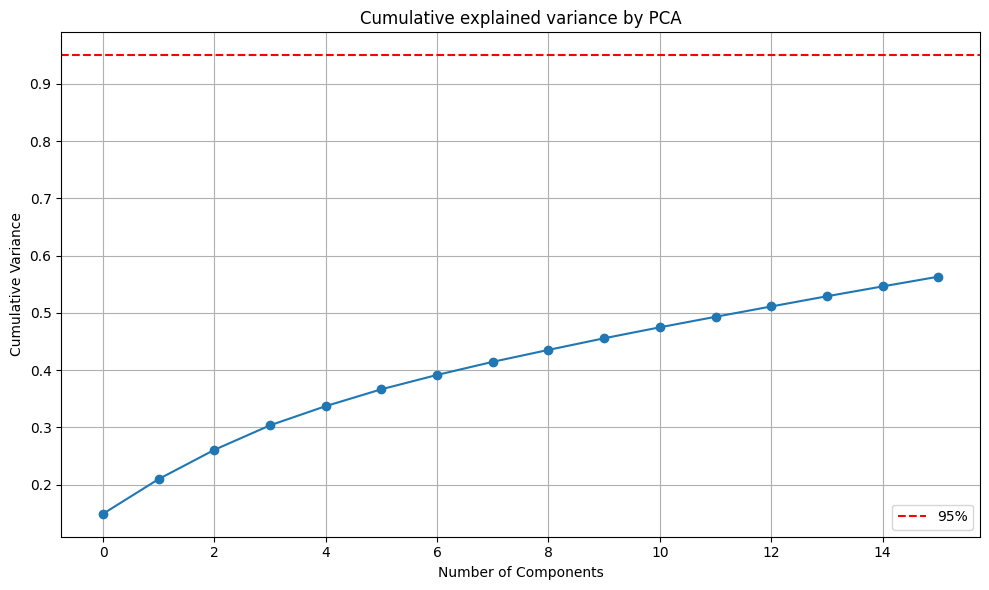

In [22]:
# 💡 Now we will check the variance explained by each component:
explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)
printing(f"Total variance: {total_variance:.4f} ({total_variance * 100:.2f}%)")
print("🔍 Variance explained by each component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({var * 100:.2f}%)")

# Cumulative chart
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative explained variance by PCA')
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--', label='95%')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# We calculate the PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# We show the 5 variables with the greatest contribution (by absolute value) for each component
top_features_per_pc = {}

for pc in loadings.columns:
    top_vars = loadings[pc].abs().sort_values(ascending=False).head(5)
    top_features_per_pc[pc] = top_vars.index.tolist()

top_features_df = pd.DataFrame(top_features_per_pc)
top_features_df.index = [f'Top {i+1}' for i in range(5)]

top_features_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Top 1,Overall Qual,2nd Flr SF,1st Flr SF,Bsmt Unf SF,Bldg Type,Kitchen AbvGr,Overall Cond,Neighborhood,Neighborhood,Garage Cond,Lot Config,Low Qual Fin SF,Condition 1,Mo Sold,Lot Config,Bsmt Half Bath
Top 2,Year Built,TotRms AbvGrd,Lot Frontage,BsmtFin Type 1,MS SubClass,Garage Qual,MS Zoning,Land Slope,Screen Porch,Garage Qual,Bsmt Half Bath,Roof Style,Street,Utilities,Roof Matl,Pool Area
Top 3,Garage Yr Blt,Bedroom AbvGr,MS SubClass,House Style,Kitchen AbvGr,Kitchen Qual,Street,Fireplaces,Roof Style,Exter Cond,Roof Matl,Pool Area,Condition 2,Condition 1,Exter Cond,Lot Config
Top 4,Bsmt Qual,Gr Liv Area,Bldg Type,2nd Flr SF,Central Air,Garage Cond,Lot Frontage,Fireplace Qu,Mas Vnr Area,Utilities,Neighborhood,Utilities,Heating,3Ssn Porch,Lot Shape,Functional
Top 5,Garage Cars,BsmtFin SF 1,Total Bsmt SF,Half Bath,Overall Cond,Paved Drive,Central Air,BsmtFin Type 1,Exterior 1st,Street,Bsmt Exposure,Bsmt Half Bath,Utilities,Condition 2,Land Slope,3Ssn Porch


## 💡 Training the model and evaluating its performance

In [24]:
# Split data PCA + target (SalePrice):

# X_pca is already scaled and transformed by PCA
# and is an ndarray. and is the original target.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)


In [25]:
# ✅ 2. Train linear regression
# Crear y entrenar el modelo
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = reg_model.predict(X_test)
errors = print_error_metrics(y_test, y_pred, 'Linear Regression')


Error metrics for Linear Regression:
📏 MAE (SVR Linear Regression): 18,283.18
📏 MSE (SVR Linear Regression): 618,294,520.99
📏 R2 (SVR Linear Regression): 0.87


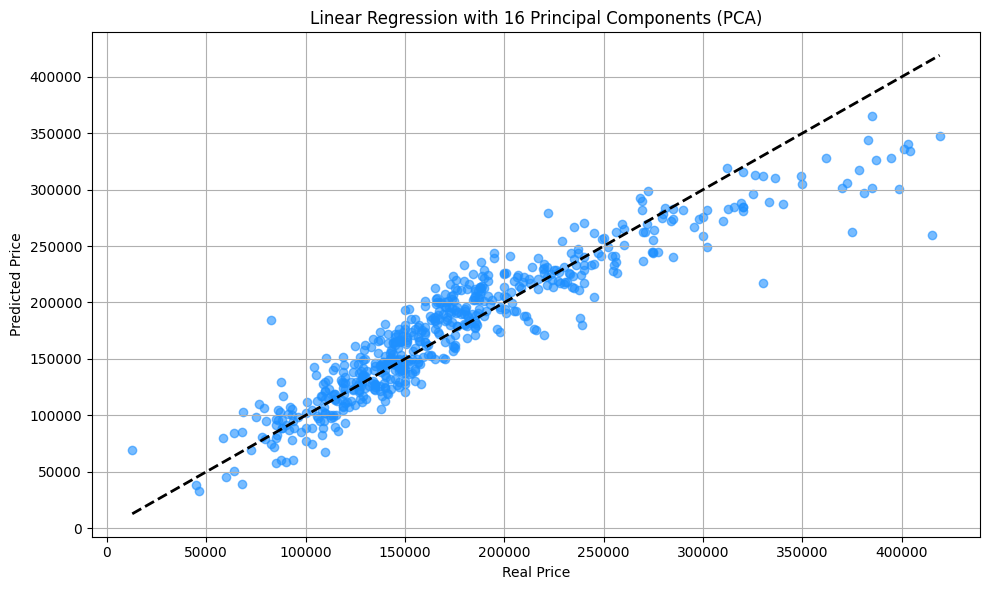

In [ ]:
# 💡 Now we plot the model response:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression with 16 Principal Components (PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

### ✅ Conclusion - PCA + Linear Regression

Based on the **16 principal components** generated by PCA, a **linear regression model** was trained and achieved strong performance, reaching an **R² score of 0.87** and a **MAE close to $18,000**.

This demonstrates that, although the components retain only **56% of the original variance**, they contain enough relevant information to accurately predict housing prices.

➡️ **Dimensionality reduction proved effective**, allowing simplification of the dataset without significantly compromising the model's predictive power.


## 🚀 Now we go one step further:
### Getting the optimal number of components to preserve 90% of the variance

      PC  Explained Variance  Cumulative Variance
0    PC1            0.149056             0.149056
1    PC2            0.060705             0.209761
2    PC3            0.051029             0.260790
3    PC4            0.042824             0.303614
4    PC5            0.033536             0.337150
5    PC6            0.029413             0.366563
6    PC7            0.025051             0.391615
7    PC8            0.022910             0.414525
8    PC9            0.020817             0.435342
9   PC10            0.020323             0.455665
10  PC11            0.019122             0.474787
11  PC12            0.018359             0.493146
12  PC13            0.018046             0.511192
13  PC14            0.017820             0.529012
14  PC15            0.017226             0.546238
15  PC16            0.016946             0.563184
16  PC17            0.016305             0.579489
17  PC18            0.016040             0.595529
18  PC19            0.015820             0.611349


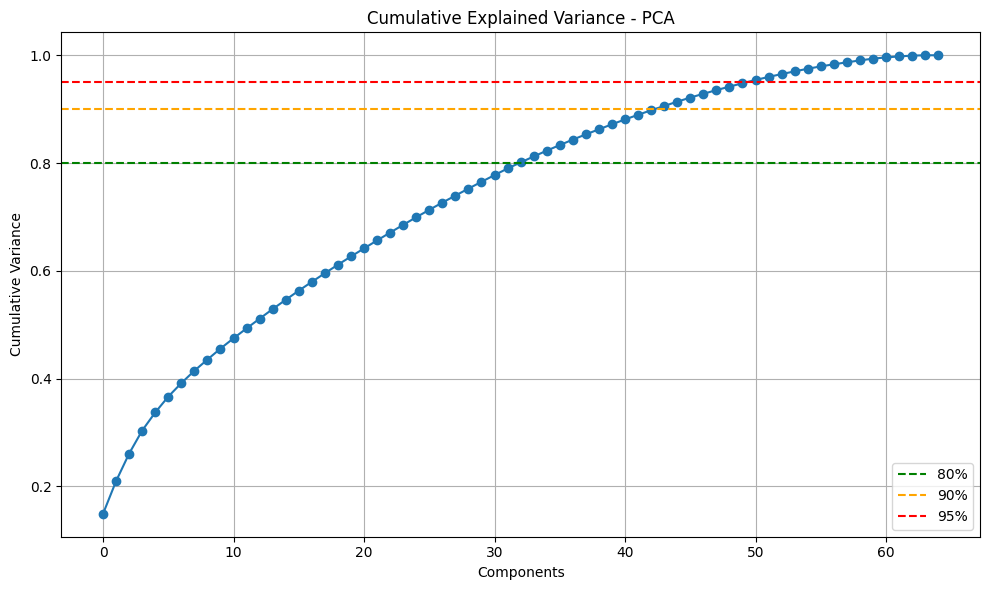

In [27]:
# We repeat PCA without limiting n_components
pca_full = make_pipeline(
    StandardScaler(),
    PCA()
)

# Fit to the entire dataset
X_pca_full = pca_full.fit_transform(X)
pca_model_full = pca_full.named_steps['pca']

# Explained variance
explained_var = pca_model_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Creating summary DataFrame:
pca_summary = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_var))],
    'Explained Variance': explained_var,
    'Cumulative Variance': cumulative_var
})

# Showing the first 25 rows of the summary:
print(pca_summary.head(25))

# Plotting the explained variance:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_var, marker='o')
plt.axhline(0.80, color='green', linestyle='--', label='80%')
plt.axhline(0.90, color='orange', linestyle='--', label='90%')
plt.axhline(0.95, color='red', linestyle='--', label='95%')
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Explained Variance - PCA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
# Desired threshold (adjustable)
target_variance = 0.90

# Find the minimum amount of components needed
n_components_90 = np.argmax(cumulative_var >= target_variance) + 1
print(f"✅ To preserve at least the {target_variance*100:.0f}% of the variance, it is necessary {n_components_90} components.")


✅ To preserve at least the 90% of the variance, it is necessary 44 components.


## 💡 Creating the optimal PCA pipeline, training, and predicting

In [29]:
# Create the optimal PCA pipeline
# with the desired number of components
optimal_pca_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=n_components_90)
)

# Fit the pipeline to the data
X_pca_opt = optimal_pca_pipeline.fit_transform(X)
print(f"X_pca_opt shape: {X_pca_opt.shape}")


X_pca_opt shape: (2885, 44)


Error metrics for Linear Regression with PCA (90% variance):
📏 MAE (SVR Linear Regression with PCA (90% variance)): 18,367.01
📏 MSE (SVR Linear Regression with PCA (90% variance)): 625,697,913.51
📏 R2 (SVR Linear Regression with PCA (90% variance)): 0.87


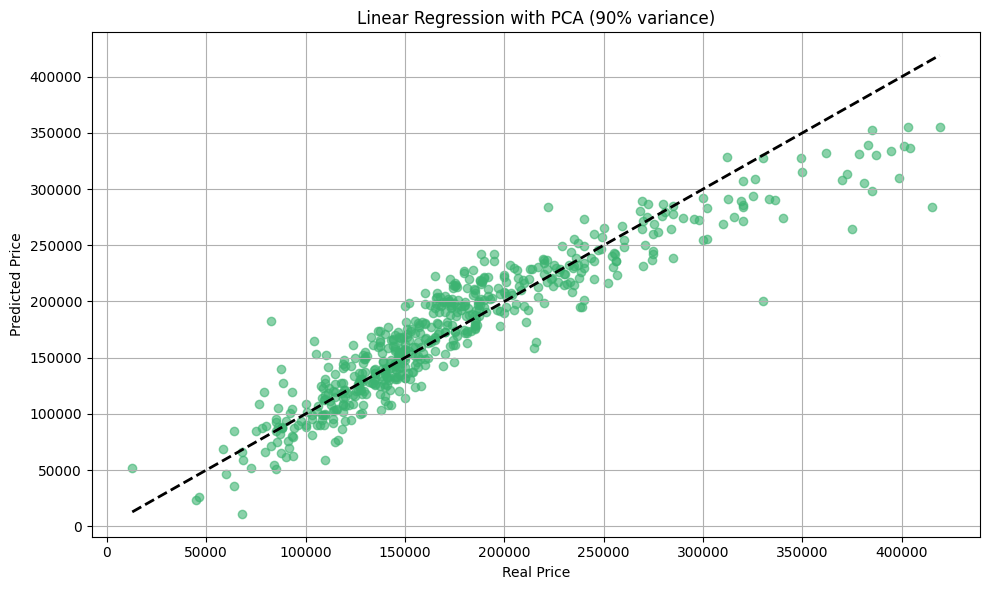

In [30]:
# 💡 Now we split the data into test and train:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_opt, y, test_size=0.2, random_state=42
)
# Create and train the model
reg_pca_model = LinearRegression()
reg_pca_model.fit(X_train, y_train)

# Predictions
y_pred = reg_pca_model.predict(X_test)

print_error_metrics(y_test, y_pred, 'Linear Regression with PCA (90% variance)')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression with PCA (90% variance)")
plt.grid(True)
plt.tight_layout()
plt.show()


### ✅ Conclusión Final - Trabajo Práctico 4

En esta etapa se implementó un análisis de **reducción de dimensionalidad utilizando PCA (Análisis de Componentes Principales)**, seguido de un modelo de **regresión lineal** aplicado sobre los componentes obtenidos.

Se compararon dos configuraciones de PCA:

1. **PCA con 16 componentes fijos** (sin optimización)
2. **PCA con número de componentes ajustado para preservar el 90% de la varianza** (44 componentes)

#### 📊 Resultados de rendimiento:

| Modelo                         | MAE ($)     | MSE ($)             | R²     |
|-------------------------------|-------------|----------------------|--------|
| PCA (16 componentes)          | 18,283.18   | 618,294,520.99       | 0.87   |
| PCA (90% varianza, 44 comps.) | 18,367.01   | 625,697,913.51       | 0.87   |

Ambas configuraciones obtuvieron un desempeño prácticamente **idéntico**, alcanzando un **R² de 0.87** y un **MAE cercano a $18.000**, lo cual refleja un excelente nivel de precisión para el modelo, aun después de la reducción dimensional.

### 🧠 Conclusión técnica:

> Tanto la versión reducida (16 componentes) como la optimizada (90% varianza) lograron **preservar la capacidad predictiva** del modelo.  
> Esto demuestra que PCA es una técnica efectiva para simplificar los datos del problema sin sacrificar rendimiento, mejorando la interpretabilidad y reduciendo el costo computacional.

➡️ Se valida así el uso de PCA como técnica complementaria en el pipeline de machine learning aplicado a problemas de regresión.
